In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [3]:
var_name = 'pr'
df_var = df[(df.table_id == 'Amon') & (df.variable_id == var_name)
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
len(df_var)

278

In [4]:
run_counts = df_var.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id        experiment_id
BCC-CSM2-MR      1pctCO2           1
                 historical        3
                 piControl         1
BCC-ESM1         1pctCO2           1
                 historical        3
                 piControl         1
CAMS-CSM1-0      1pctCO2           2
                 historical        2
                 piControl         1
CESM2            1pctCO2           1
                 historical       10
                 piControl         1
CESM2-WACCM      1pctCO2           1
                 historical        3
                 piControl         1
CNRM-CM6-1       1pctCO2           1
                 historical       14
                 piControl         1
CNRM-ESM2-1      1pctCO2           4
                 historical        5
                 piControl         1
CanESM5          1pctCO2           6
                 historical       50
                 piControl         2
E3SM-1-0         1pctCO2           1
                 historical        5
       

In [5]:
source_ids = []
experiment_ids = ['historical', 'piControl', '1pctCO2']
for name, group in df_var.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [6]:
def load_tas_data(source_id, expt_id):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 1.)),
                     'lon': (['lon'], np.arange(0.5, 360., 1.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [7]:
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical').sel(time=slice('1980', '2014')).mean(dim='time')

In [8]:
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical')
ds['pr']

<xarray.DataArray 'pr' (time: 1980, lat: 160, lon: 320)>
dask.array<zarr, shape=(1980, 160, 320), dtype=float32, chunksize=(600, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean (interval: 5 minutes)
    comment:        includes both liquid and solid phases
    long_name:      Precipitation
    original_name:  PRECT
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

In [9]:
source_id = source_ids[:5]

In [12]:
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [14]:
for source_id in tqdm(source_ids[:5]):

    ds = (load_tas_data(source_id, 'historical')
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))

In [15]:
ds

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds  (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds  (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    pr        (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>

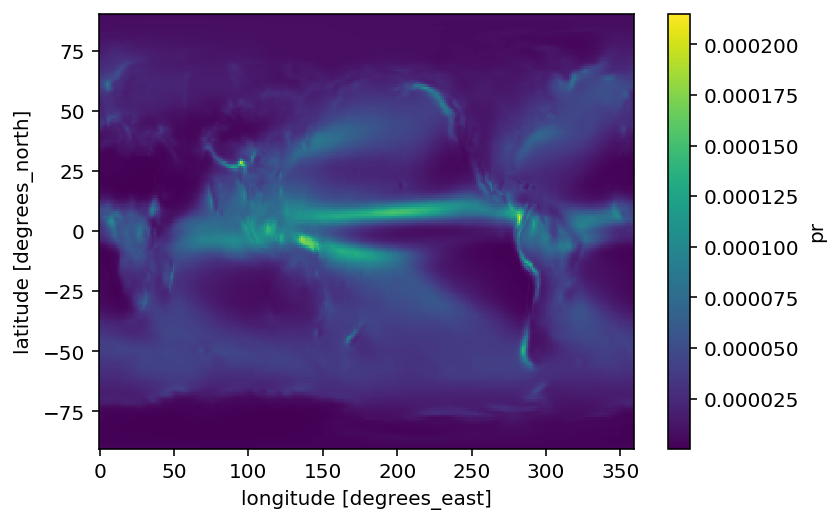

In [17]:
q = (ds.pr).plot(x='lon', y='lat', col_wrap=6)

In [ ]:
q = (ens-obs).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

In [10]:
source_id

['BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM']

In [11]:
for source_id in tqdm(source_ids):
    ds = load_tas_data(source_id, 'historical')
    ds['pr']

In [18]:
### testing variables
results = {}

first = 1
for source_id in tqdm(source_ids[:5]):
    # take 1980-2019 mean
    ds = (load_tas_data(source_id, 'historical')
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
#    elif ('longitude' in ds.dims) and ('latitude' in ds.dims):
#        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens_test = ds_new
        first = 0
    else:
        ens_test = xr.concat([ens_test, ds_new], pd.Index(np.append(ens_test.ensemble.values, ds_new.attrs['name']), name='ensemble'))

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc



In [19]:
ens_test

<xarray.DataArray 'pr' (ensemble: 5, lat: 178, lon: 360)>
dask.array<concatenate, shape=(5, 178, 360), dtype=float64, chunksize=(1, 178, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * ensemble  (ensemble) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'CESM2-WACCM'
Attributes:
    regrid_method:  bilinear

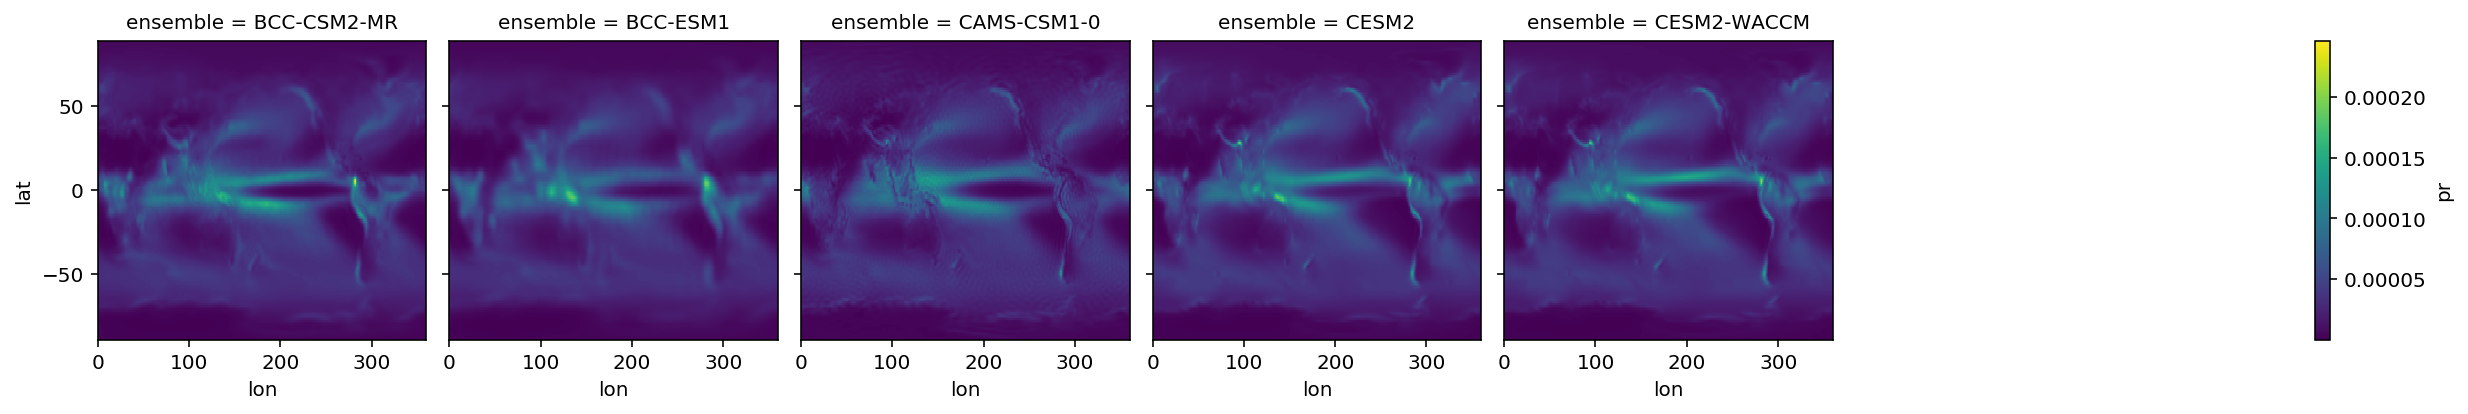

In [20]:
q = (ens_test).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

In [21]:
source_ids[2]

'CAMS-CSM1-0'

In [37]:
ds = load_tas_data(source_ids[2], 'historical')
ds['pr']

<xarray.DataArray 'pr' (time: 1980, lat: 160, lon: 320)>
dask.array<zarr, shape=(1980, 160, 320), dtype=float32, chunksize=(600, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-07-01T12:19:04Z altered by CMOR: Inverted axis: lat.
    long_name:      Precipitation
    original_name:  precip
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

In [ ]:
ds['pr'][0, :, :].plot()

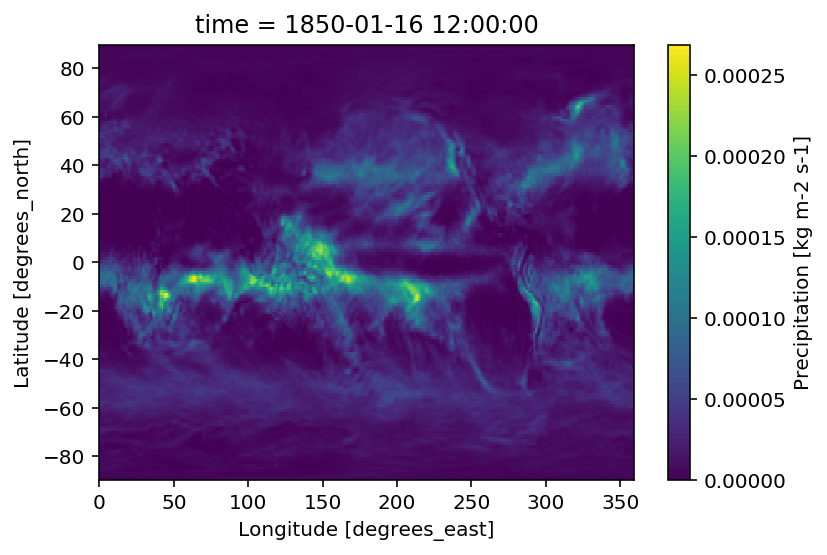

In [38]:
ds['pr'][0, :, :].plot()

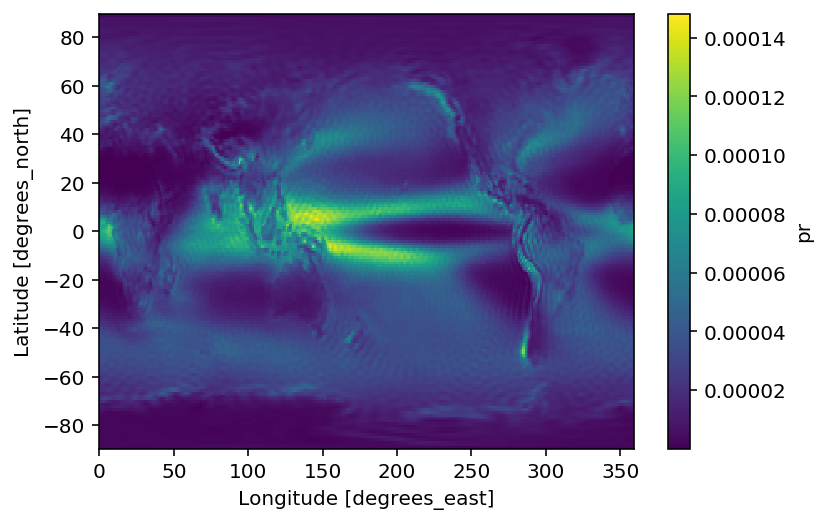

In [33]:
ds['pr'].sel(time=slice('1980', '2014')).mean(dim='time').plot()

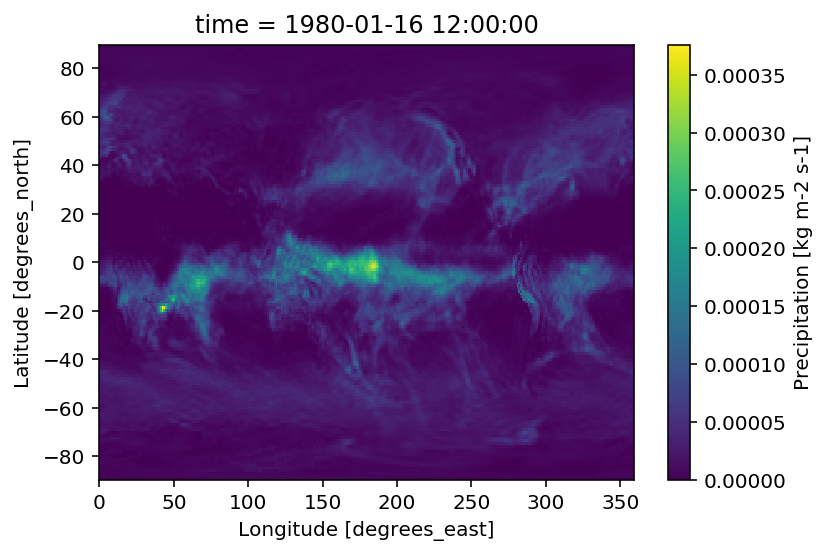

In [49]:
testing = ds['pr'].sel(time=slice('1980', '2014'))
testing[0, :, :].plot()

In [51]:
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [54]:
source_ids.remove('MCM-UA-1-0') # units are off for precipitation 

In [39]:
ds2 = load_tas_data(source_ids[16], 'historical')
ds2['pr']

<xarray.DataArray 'pr' (time: 1980, latitude: 80, longitude: 96)>
dask.array<zarr, shape=(1980, 80, 96), dtype=float32, chunksize=(600, 80, 96), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -88.29 -86.07 -83.84 ... 83.84 86.07 88.29
  * longitude  (longitude) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
  * time       (time) object 1850-01-17 00:00:00 ... 2014-12-17 00:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    long_name:      Precipitation                                         
    standard_name:  precipitation_flux
    table_id:       Amon
    units:          kg m-2 s-1

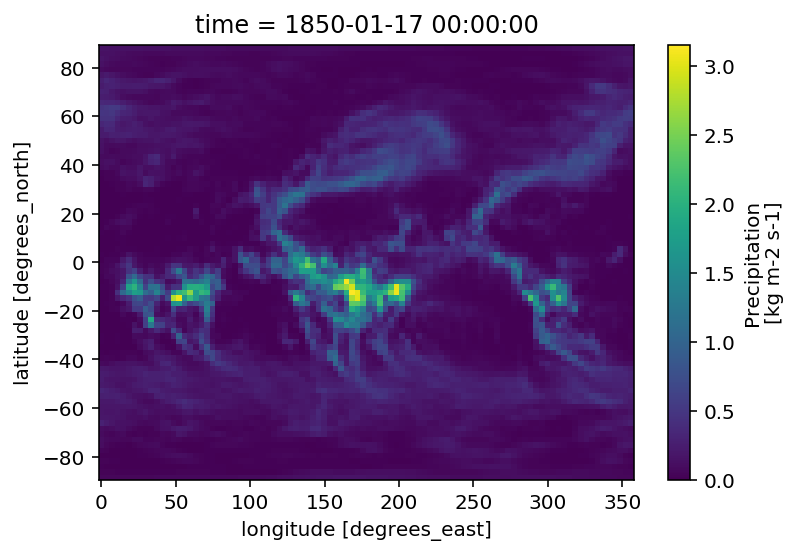

In [40]:
ds2['pr'][0, :, :].plot()

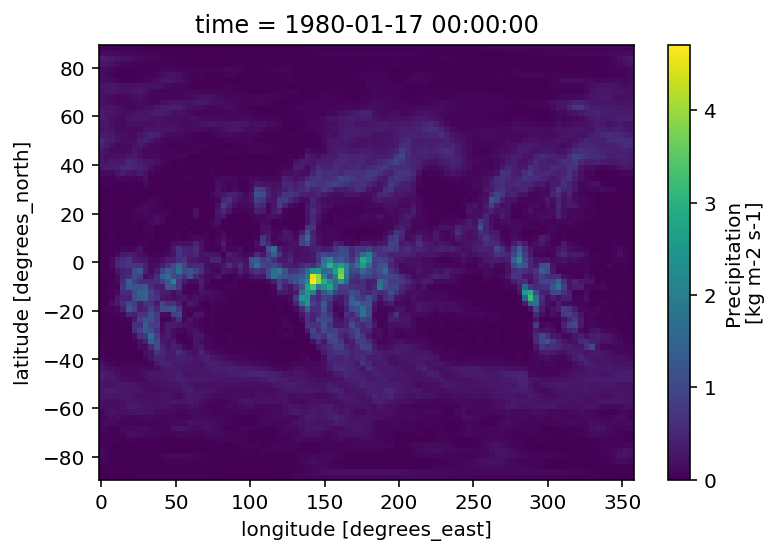

In [50]:
testing2 = ds2['pr'].sel(time=slice('1980', '2014'))
testing2[0, :, :].plot()

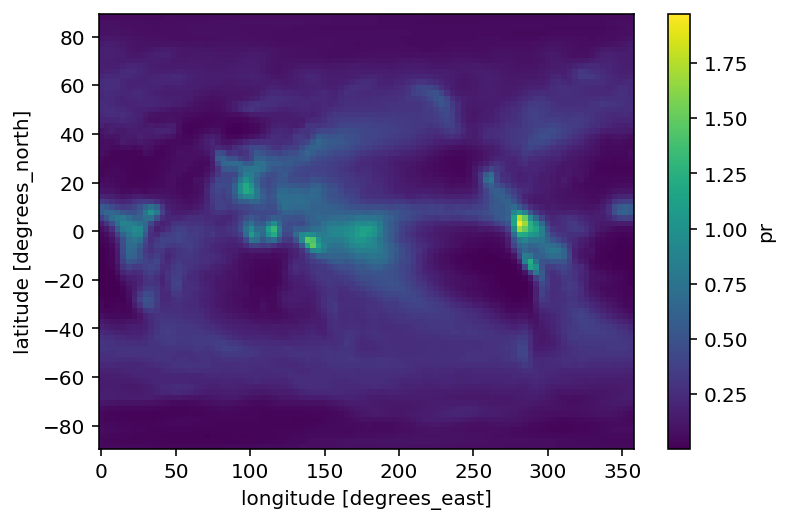

In [36]:
ds['pr'].sel(time=slice('1980', '2014')).mean(dim='time').plot()

In [ ]:
# try increasing amount of source ids and then loop through perhaps to plot a few of them and print out the units for each 
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical')
ds['pr']

In [49]:
ds['pr'].attrs

{}

In [27]:
results = {}

first = 1
for source_id in tqdm(source_ids):
    # take 1980-2019 mean
    ds = (load_tas_data(source_id, 'historical')
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
#    elif ('longitude' in ds.dims) and ('latitude' in ds.dims):
#        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens = ds_new
        first = 0
    else:
        ens = xr.concat([ens, ds_new], pd.Index(np.append(ens.ensemble.values, ds_new.attrs['name']), name='ensemble'))

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_180x360_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_80x96_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x2

In [28]:
ens

<xarray.DataArray 'pr' (ensemble: 22, lat: 178, lon: 360)>
dask.array<concatenate, shape=(22, 178, 360), dtype=float64, chunksize=(1, 178, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * ensemble  (ensemble) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL'
Attributes:
    regrid_method:  bilinear

In [29]:
# Use multi-model mean as temporary stand-in for observations
obs = ens.mean(dim='ensemble').compute()

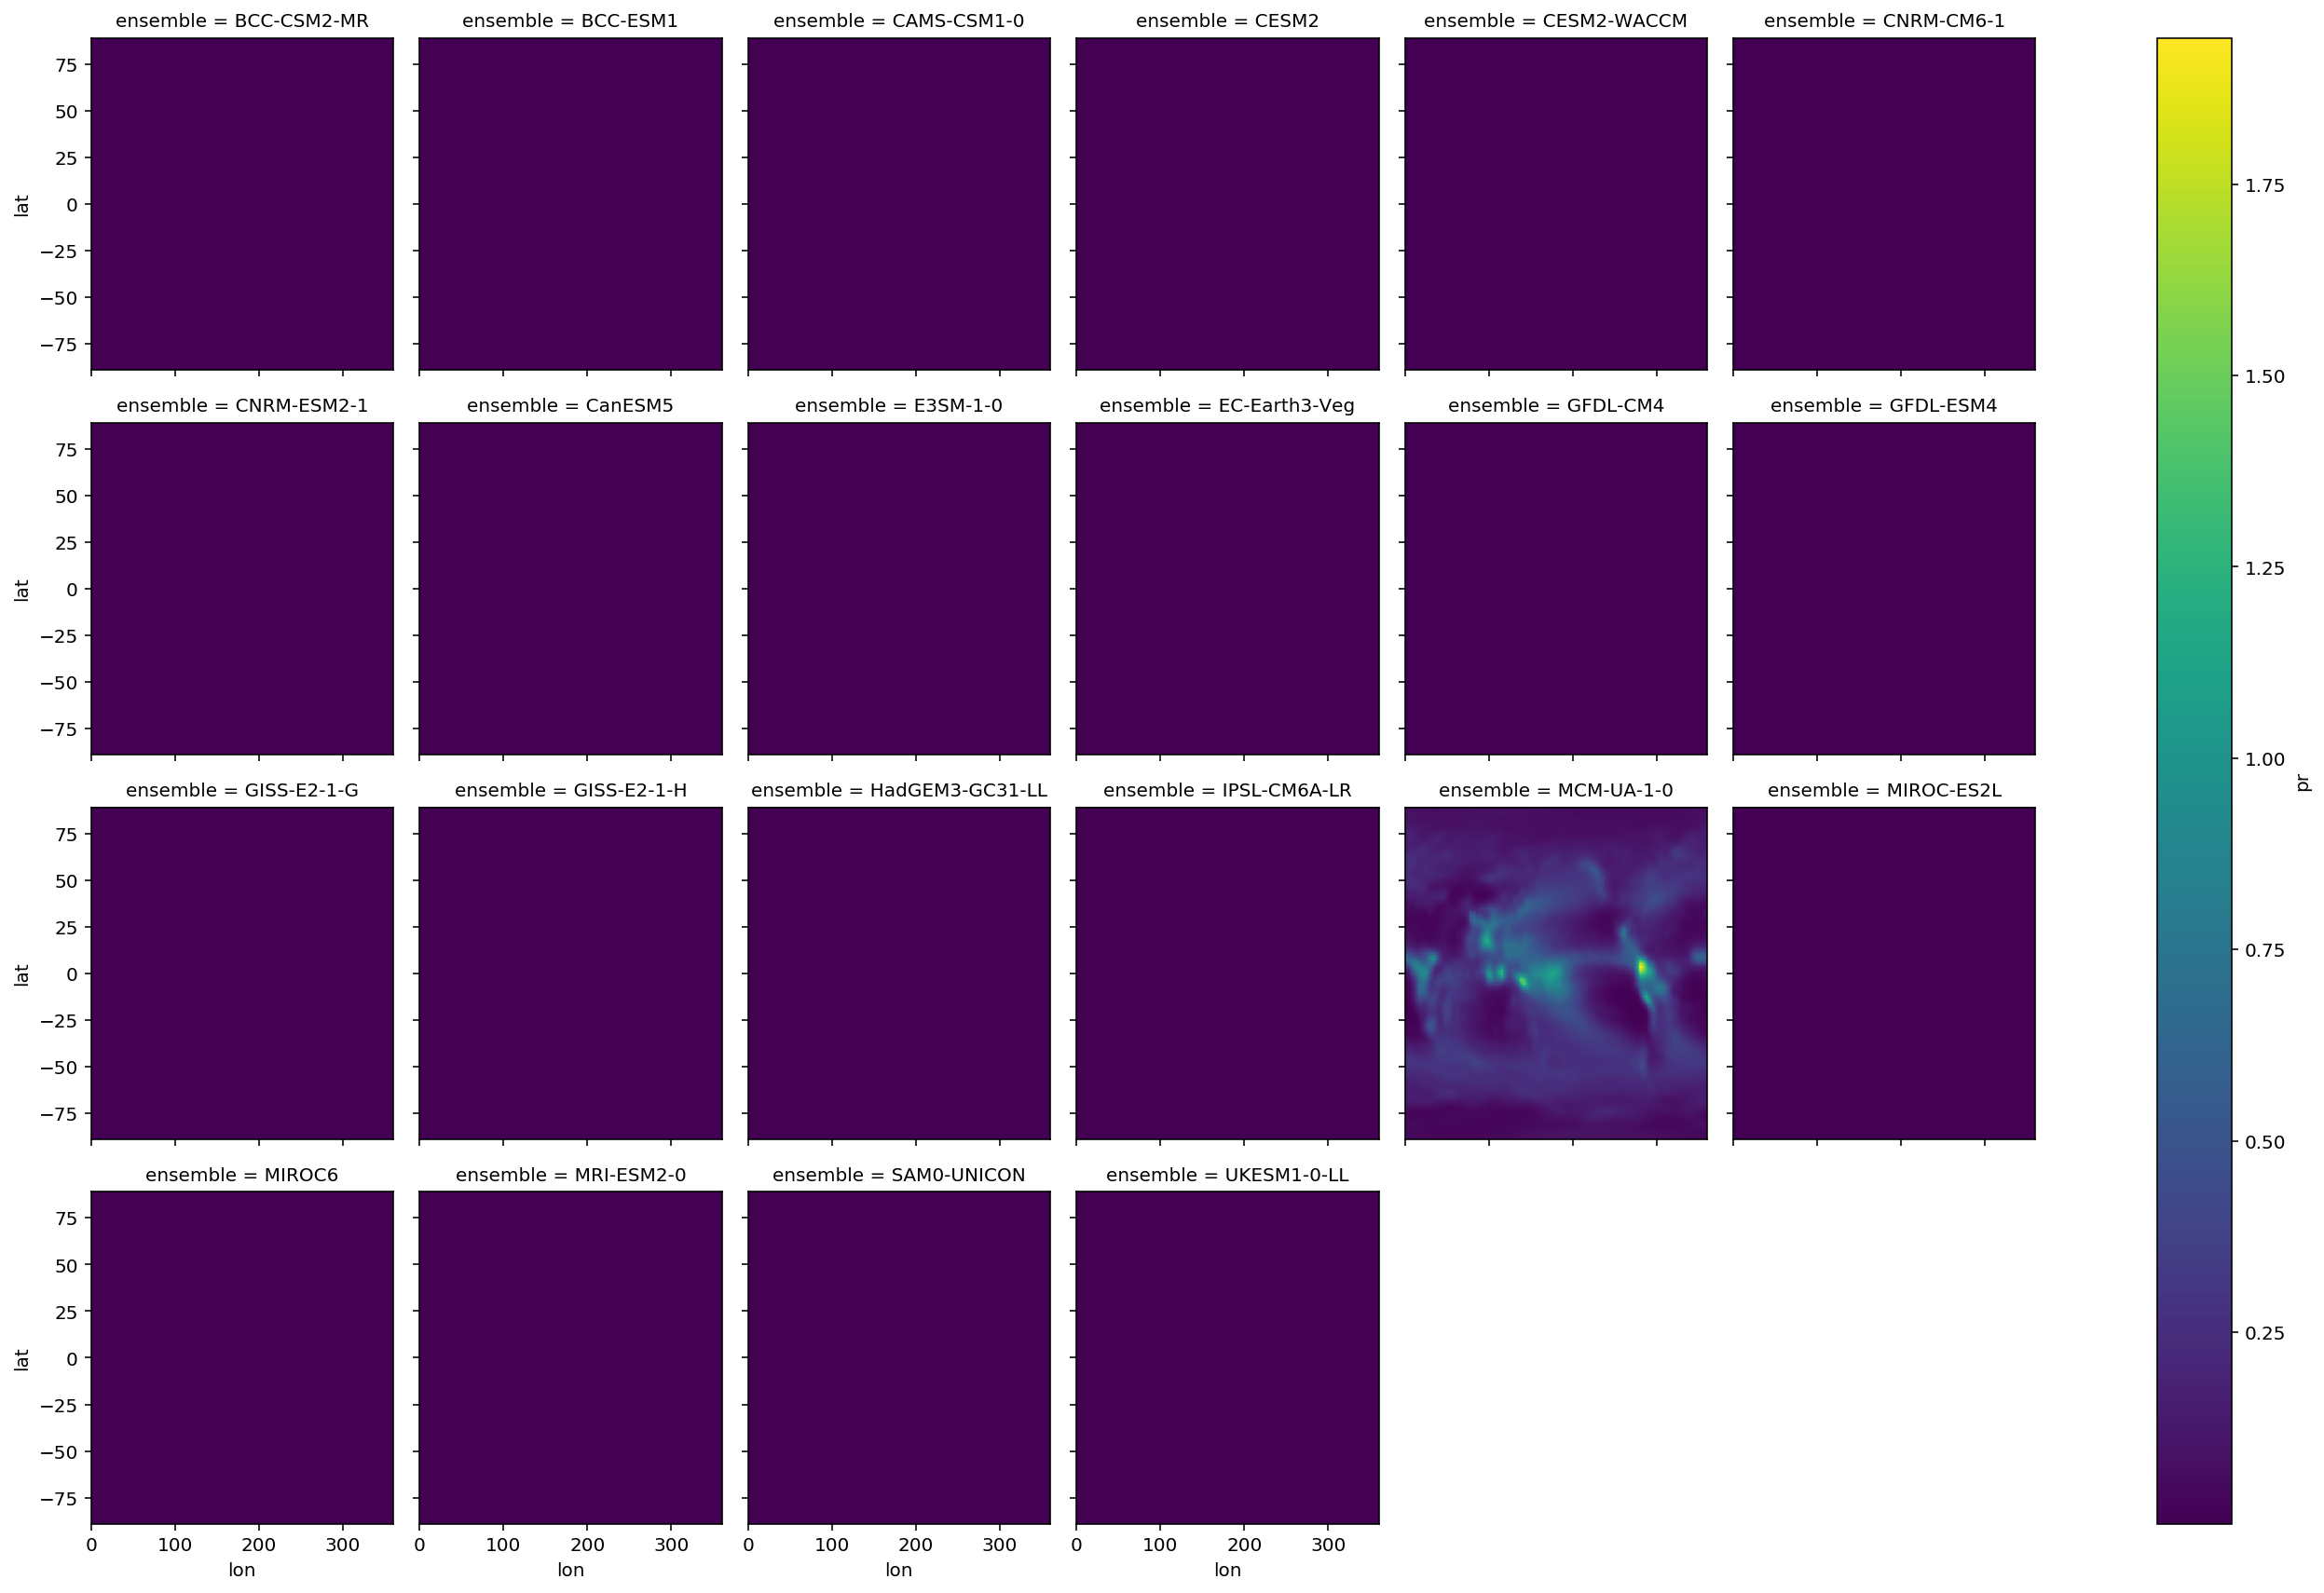

In [41]:
q = (ens).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

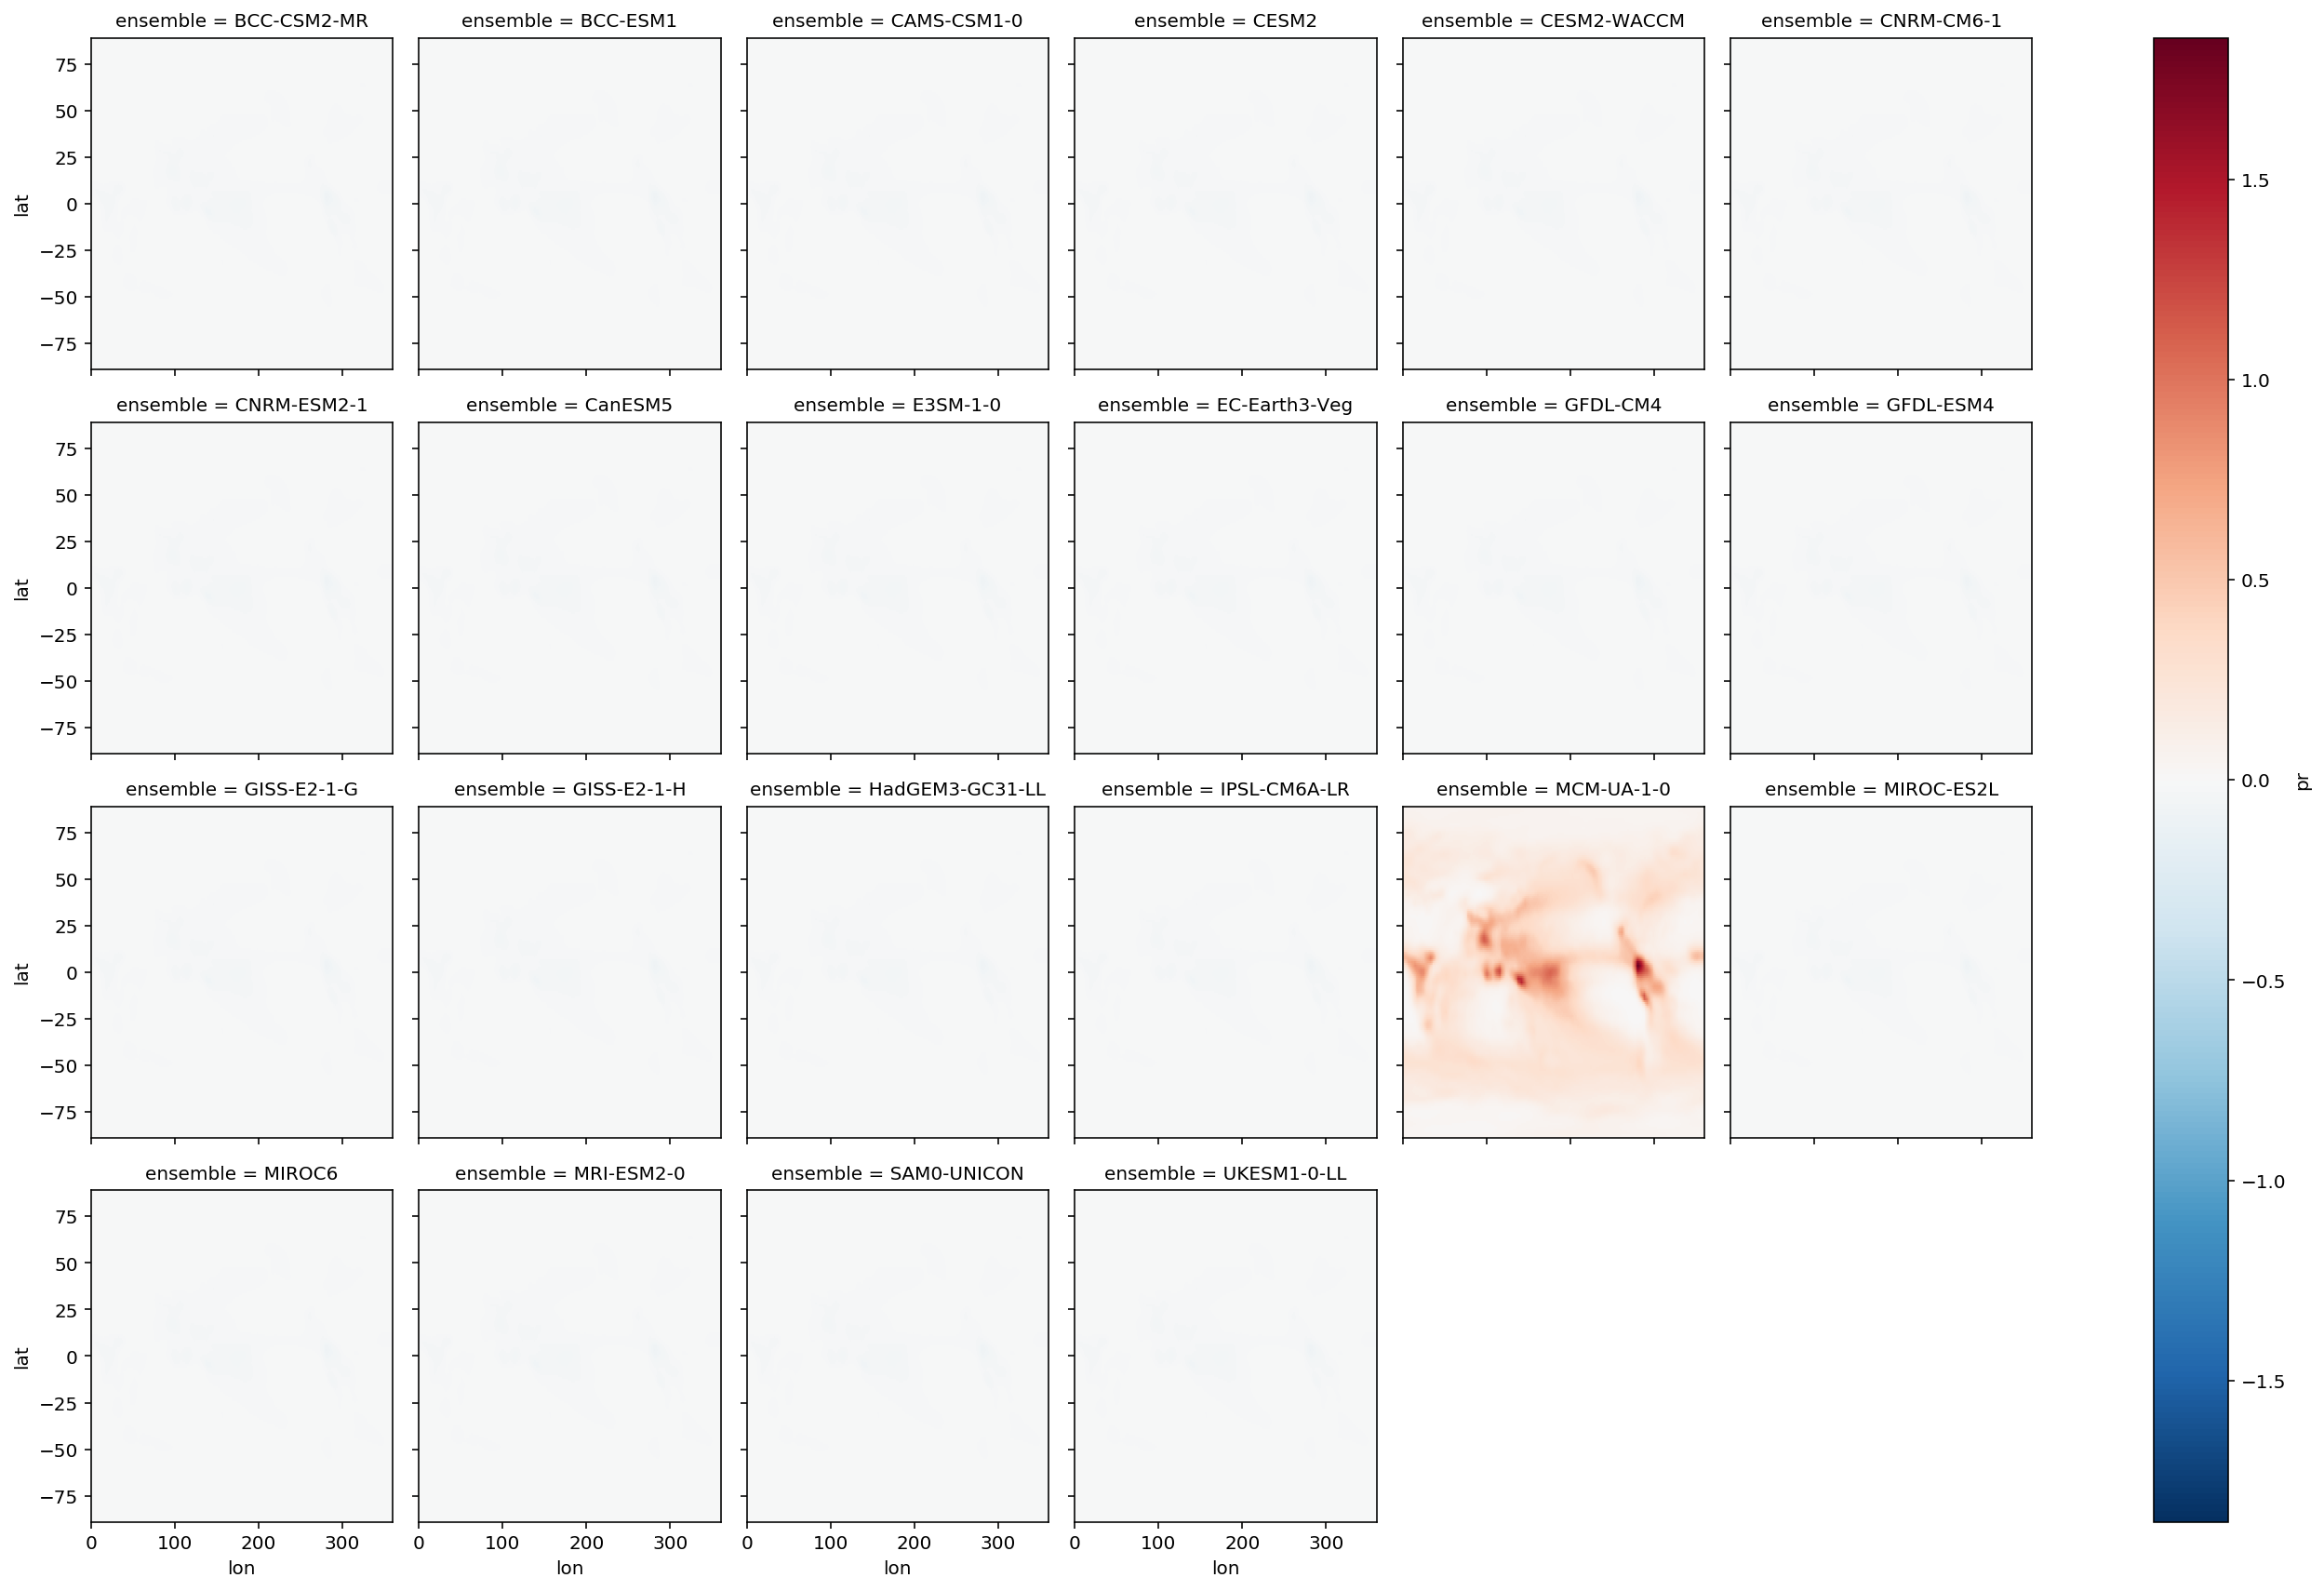

In [30]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q = (ens-obs).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

In [31]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens.attrs['rmse'] = {}
ens.attrs['mae'] = {}
for ensemble in ens.ensemble:
    ds = ens.sel(ensemble=ensemble)
    ens.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs, ds, ['lat', 'lon']).values
    ens.attrs['mae'][str(ensemble.values)] = xs.mae(obs, ds, ['lat', 'lon']).values
ens.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array(0.0127986),
  'BCC-ESM1': array(0.01280024),
  'CAMS-CSM1-0': array(0.01280247),
  'CESM2': array(0.01279798),
  'CESM2-WACCM': array(0.0127985),
  'CNRM-CM6-1': array(0.01280085),
  'CNRM-ESM2-1': array(0.01280017),
  'CanESM5': array(0.01279945),
  'E3SM-1-0': array(0.01279862),
  'EC-Earth3-Veg': array(0.01279947),
  'GFDL-CM4': array(0.0127993),
  'GFDL-ESM4': array(0.01279925),
  'GISS-E2-1-G': array(0.01280034),
  'GISS-E2-1-H': array(0.01279956),
  'HadGEM3-GC31-LL': array(0.01279688),
  'IPSL-CM6A-LR': array(0.01279842),
  'MCM-UA-1-0': array(0.2687789),
  'MIROC-ES2L': array(0.01279763),
  'MIROC6': array(0.01279643),
  'MRI-ESM2-0': array(0.01279811),
  'SAM0-UNICON': array(0.0127994),
  'UKESM1-0-LL': array(0.01279725)},
 'mae': {'BCC-CSM2-MR': array(0.00987888),
  'BCC-ESM1': array(0.00988065),
  'CAMS-CSM1-0': array(0.00988042),
  'CESM2': array(0.00987866),
  'CESM2-WACCM': array(0.00987889),
  'CNRM-CM6-1': arr

Text(0, 0.5, 'Root-Mean Square Error [K]')

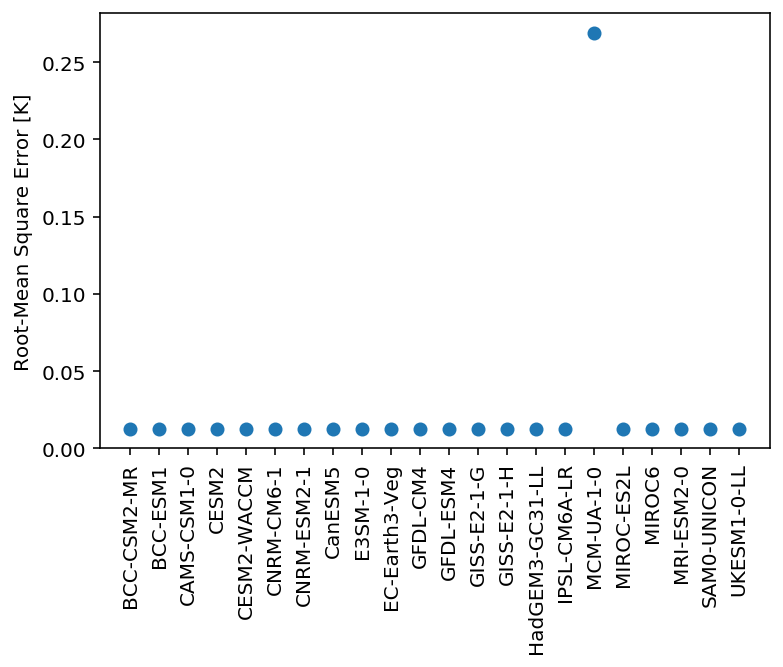

In [32]:
plt.plot(list(ens.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
#plt.ylim([0,4.25])

In [33]:
ens.attrs['rmse'].values()

dict_values([array(0.0127986), array(0.01280024), array(0.01280247), array(0.01279798), array(0.0127985), array(0.01280085), array(0.01280017), array(0.01279945), array(0.01279862), array(0.01279947), array(0.0127993), array(0.01279925), array(0.01280034), array(0.01279956), array(0.01279688), array(0.01279842), array(0.2687789), array(0.01279763), array(0.01279643), array(0.01279811), array(0.0127994), array(0.01279725)])

In [34]:
ens

<xarray.DataArray 'pr' (ensemble: 22, lat: 178, lon: 360)>
dask.array<concatenate, shape=(22, 178, 360), dtype=float64, chunksize=(1, 178, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat       (lat) float64 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * ensemble  (ensemble) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL'
Attributes:
    regrid_method:  bilinear
    rmse:           {'BCC-CSM2-MR': array(0.0127986), 'BCC-ESM1': array(0.012...
    mae:            {'BCC-CSM2-MR': array(0.00987888), 'BCC-ESM1': array(0.00...

In [35]:
get_rmse = np.array(list(ens.rmse.values()))
get_rmse

array([0.0127986 , 0.01280024, 0.01280247, 0.01279798, 0.0127985 ,
       0.01280085, 0.01280017, 0.01279945, 0.01279862, 0.01279947,
       0.0127993 , 0.01279925, 0.01280034, 0.01279956, 0.01279688,
       0.01279842, 0.2687789 , 0.01279763, 0.01279643, 0.01279811,
       0.0127994 , 0.01279725])

In [36]:
rmse_med = np.median(get_rmse)
rmse_med

0.012799276943170977

In [37]:
list(ens.rmse.values()) / rmse_med

array([ 0.99994748,  1.00007519,  1.00024942,  0.99989901,  0.99993944,
        1.00012299,  1.00006954,  1.00001319,  0.99994875,  1.00001531,
        1.00000201,  0.99999799,  1.00008303,  1.00002238,  0.9998125 ,
        0.99993326, 20.99953796,  0.99987168,  0.99977738,  0.99990872,
        1.00000993,  0.99984199])

In [38]:
1.65505276 / 1.677583092195523

0.9865697667672385

Text(0, 0.5, 'Normalized Root-Mean Square Error')

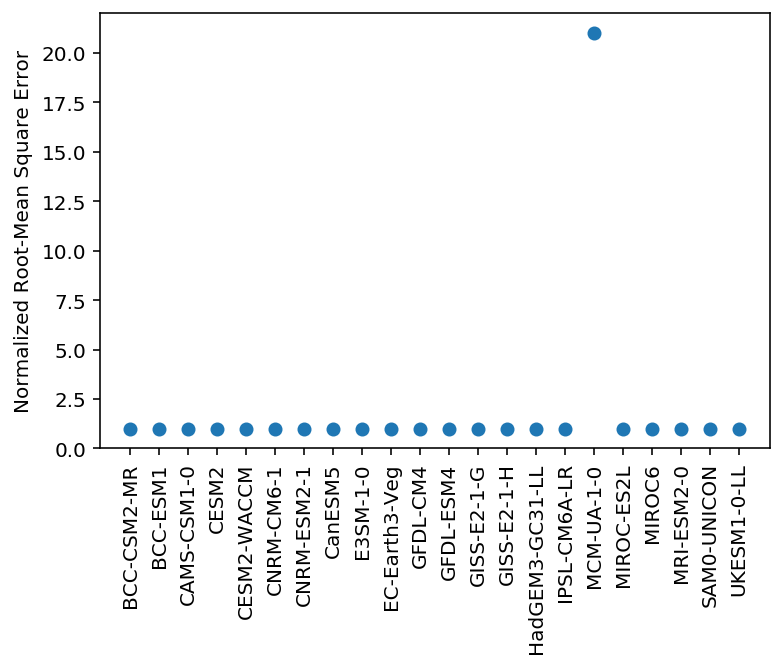

In [40]:
plt.plot((list(ens.attrs['rmse'].values()))/rmse_med,'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Normalized Root-Mean Square Error')
#plt.ylim([0,3.0])

### Now moving on to precipitation 


In [56]:
var_name = 'pr'
df_pr = df[(df.table_id == 'Amon') & (df.variable_id == var_name)
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
len(df_pr)

278

In [57]:
run_counts_pr = df_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts_pr

source_id        experiment_id
BCC-CSM2-MR      1pctCO2           1
                 historical        3
                 piControl         1
BCC-ESM1         1pctCO2           1
                 historical        3
                 piControl         1
CAMS-CSM1-0      1pctCO2           2
                 historical        2
                 piControl         1
CESM2            1pctCO2           1
                 historical       10
                 piControl         1
CESM2-WACCM      1pctCO2           1
                 historical        3
                 piControl         1
CNRM-CM6-1       1pctCO2           1
                 historical       14
                 piControl         1
CNRM-ESM2-1      1pctCO2           4
                 historical        5
                 piControl         1
CanESM5          1pctCO2           6
                 historical       50
                 piControl         2
E3SM-1-0         1pctCO2           1
                 historical        5
       

In [59]:
source_ids_pr = []
experiment_ids = ['historical', 'piControl', '1pctCO2']
for name, group in df_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids_pr.append(name)
source_ids_pr

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [60]:
### let's try to generalize this function
def load_data(source_id, expt_id, df_var):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds



In [66]:
results = {}

first = 1
for source_id in tqdm(source_ids_pr):
    # take 1980-2019 mean
    ds = (load_data(source_id, 'historical', df_pr)
          .sel(time=slice('1980', '2014'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens_pr = ds_new
        first = 0
    else:
        ens_pr = xr.concat([ens_pr, ds_new], pd.Index(np.append(ens_pr.ensemble.values, ds_new.attrs['name']), name='ensemble')) # update ens_pr here

Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_160x320_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc
Reuse existing file: bilinear_192x288_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_128x256_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_180x360_178x360_peri.nc
Reuse existing file: bilinear_256x512_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_180x288_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_90x144_178x360_peri.nc
Reuse existing file: bilinear_144x192_178x360_peri.nc
Reuse existing file: bilinear_143x144_178x360_peri.nc
Reuse existing file: bilinear_80x96_178x360_peri.nc
Reuse existing file: bilinear_64x128_178x360_peri.nc
Reuse existing file: bilinear_128x2

In [67]:
ens_pr

<xarray.DataArray 'pr' (ensemble: 22, lat: 178, lon: 360)>
dask.array<concatenate, shape=(22, 178, 360), dtype=float64, chunksize=(1, 178, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -88.5 -87.5 -86.5 -85.5 ... 85.5 86.5 87.5 88.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * ensemble  (ensemble) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL'
Attributes:
    regrid_method:  bilinear

In [68]:
# Use multi-model mean as temporary stand-in for observations
obs_pr = ens_pr.mean(dim='ensemble').compute()

In [70]:
obs_pr

<xarray.DataArray 'pr' (lat: 178, lon: 360)>
array([[0.00229449, 0.00228398, 0.00227364, ..., 0.00232552, 0.00231512,
        0.00230487],
       [0.00210005, 0.0020858 , 0.00207167, ..., 0.00213986, 0.00212672,
        0.00211369],
       [0.00195035, 0.00193311, 0.00191604, ..., 0.00199565, 0.00198089,
        0.00196628],
       ...,
       [0.00356512, 0.00357554, 0.00358555, ..., 0.00350682, 0.00352829,
        0.00354937],
       [0.00318816, 0.0031941 , 0.00319975, ..., 0.00315755, 0.00316877,
        0.00317972],
       [0.00288944, 0.0028914 , 0.00289335, ..., 0.00288166, 0.00288438,
        0.0028871 ]])
Coordinates:
  * lat      (lat) float64 -88.5 -87.5 -86.5 -85.5 -84.5 ... 85.5 86.5 87.5 88.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

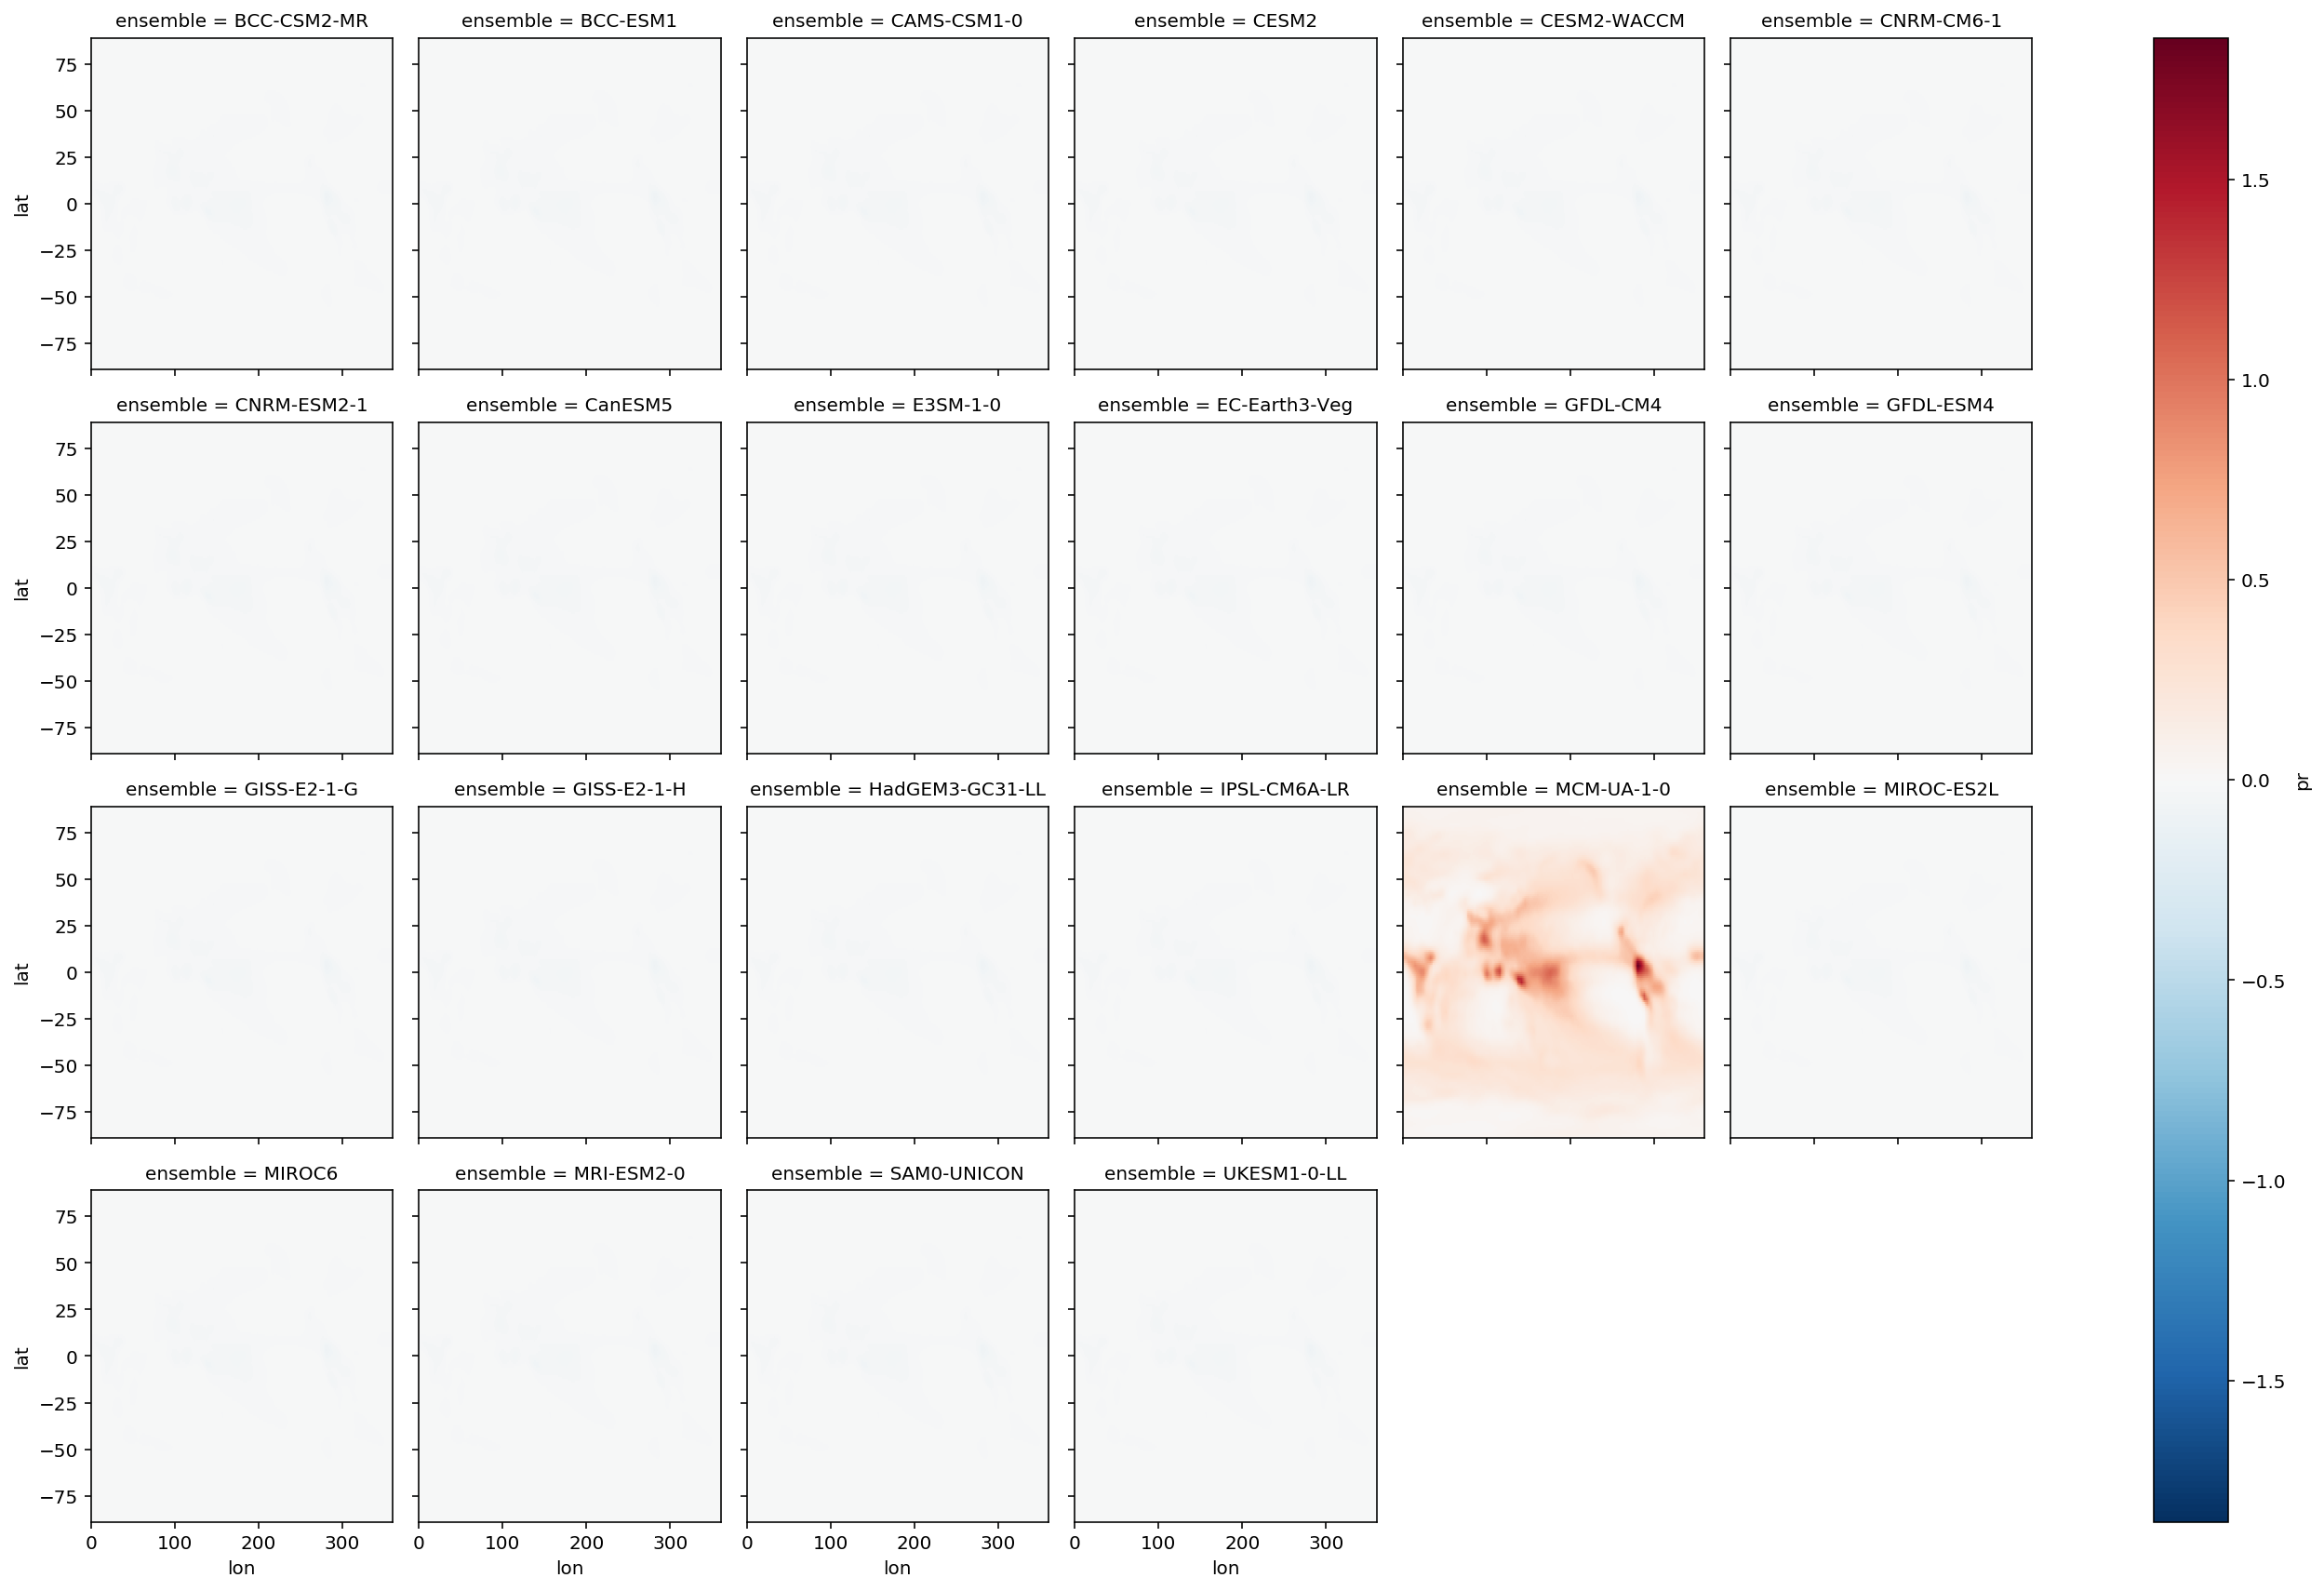

In [69]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q_pr = (ens_pr-obs_pr).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

(0, 4.25)

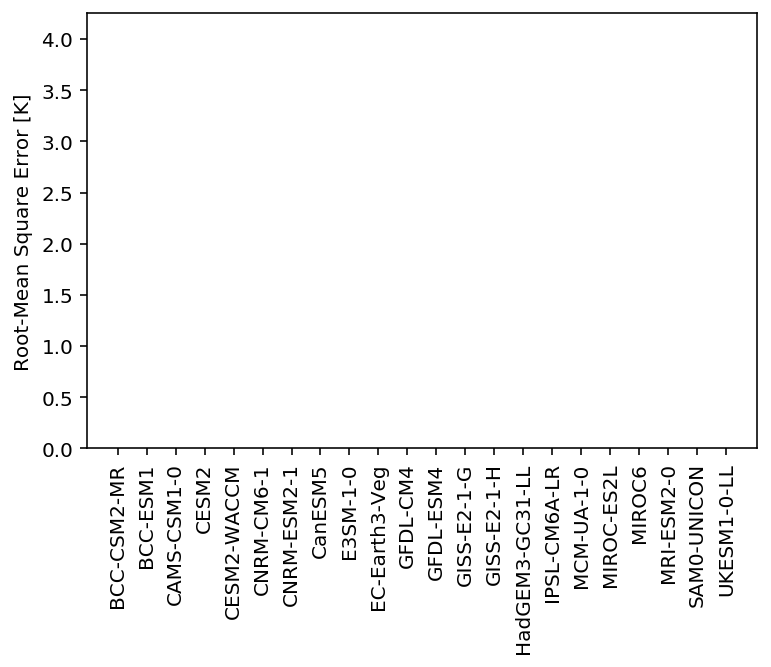

In [71]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens_pr.attrs['rmse'] = {}
ens_pr.attrs['mae'] = {}
for ensemble in ens_pr.ensemble:
    ds = ens_pr.sel(ensemble=ensemble)
    ens_pr.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs, ds, ['lat', 'lon']).values
    ens_pr.attrs['mae'][str(ensemble.values)] = xs.mae(obs, ds, ['lat', 'lon']).values
ens_pr.attrs

plt.plot(list(ens_pr.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens_pr.attrs['rmse'].keys())),list(ens_pr.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
plt.ylim([0,4.25])